<font size="6"> **Model Building** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
RND_SEED = 123
KFOLDS = 3
pd.set_option('precision', 4)


In [25]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# Ridge Model

In [4]:
hparams_ridge = {'alpha': 0.1}

In [5]:
ridge = Ridge(fit_intercept=False, random_state=RND_SEED, **hparams_ridge)

In [6]:
ridge_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=ridge, n_skip_samples=4)
ridge_nov.fit(X_train_full, y_train_full)

NoOverlapVoterRegressor(base_estimator=Ridge(alpha=0.1, copy_X=True,
                                             fit_intercept=False, max_iter=None,
                                             normalize=False, random_state=123,
                                             solver='auto', tol=0.001),
                        n_skip_samples=4)

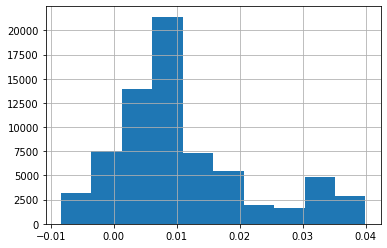

In [17]:
p_train_ridge_nov = pd.Series(index=y_train_full.index, data=ridge_nov.predict(X_train_full))
p_test_ridge_nov = pd.Series(index=y_test_full.index, data=ridge_nov.predict(X_test_full))
p_test_ridge_nov.hist()

In [8]:
ridge_nov_sum_df = mle_utils.predict_and_score(ridge_nov,
                                        X_train_full, y_train_full,
                                        X_test_full, y_test_full, kind='reg')
ridge_nov_sum_df

train_pmean           0.0040
train_score           0.0008
valid_pmean           0.0108
valid_score           0.0016
train_acc_target<0    0.3154
train_acc_target>0    0.7695
train_acc             0.5708
valid_acc             0.5125
valid_acc_target<0    0.1538
valid_acc_target>0    0.8644
dtype: float64

# Random Forest Model

In [9]:
hparams_rf = {'max_samples': 0.75,
            'max_features': 0.75,
            'min_samples_leaf': 500}

In [10]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED, **hparams_rf)

In [11]:
rf_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=rf, n_skip_samples=4)
rf_nov.fit(X_train_full, y_train_full)

NoOverlapVoterRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             criterion='mse',
                                                             max_depth=None,
                                                             max_features=0.75,
                                                             max_leaf_nodes=None,
                                                             max_samples=0.75,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=500,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                     

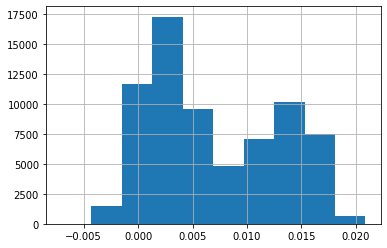

In [14]:
p_train_rf_nov = pd.Series(index=y_train_full.index, data=rf_nov.predict(X_train_full))
p_test_rf_nov = pd.Series(index=y_test_full.index, data=rf_nov.predict(X_test_full))
p_test_rf_nov.hist()

In [13]:
rf_nov_sum_df = mle_utils.predict_and_score(rf_nov,
                                        X_train_full, y_train_full,
                                        X_test_full, y_test_full, kind='reg')
rf_nov_sum_df

train_pmean           0.0034
train_score           0.0007
valid_pmean           0.0070
valid_score           0.0014
oob_score             0.2250
train_acc_target<0    0.4971
train_acc_target>0    0.7908
train_acc             0.6623
valid_acc             0.5165
valid_acc_target<0    0.0741
valid_acc_target>0    0.9504
dtype: float64

# Final Assessment

In [19]:
p_train = p_train_rf_nov.to_frame('rf_nov')
p_train['ridge_nov'] = p_train_ridge_nov
p_train.corr()

,rf_nov,ridge_nov
rf_nov,1.0000,0.5817
ridge_nov,0.5817,1.0000


In [29]:
p_test = p_test_rf_nov.to_frame('rf_nov')
p_test['ridge_nov'] = p_test_ridge_nov
p_test.corr()

,rf_nov,ridge_nov
rf_nov,1.0000,0.7639
ridge_nov,0.7639,1.0000
